In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pandas.io.formats.style import Styler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

import os
import sys
import datetime
from tqdm import tqdm

import optuna
import wandb

import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgbm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from umap import UMAP

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
from src.data_processing.fi import get_fi
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [3]:
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

In [4]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

wandb.init(project='S3E10', name='XGBoost', group='XGBoost')
config = wandb.config

In [5]:
scaler = StandardScaler()
config['scaler'] = "standard"

scaled_tr = pd.DataFrame(scaler.fit_transform(train.drop("Class", axis=1)), columns=train.drop("Class", axis=1).columns)
scaled_tr["Class"] = train["Class"]

scaled_orig = pd.DataFrame(scaler.fit_transform(orig.drop("Class", axis=1)), columns=orig.drop("Class", axis=1).columns)
scaled_orig["Class"] = orig["Class"]

scaled_tst = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [6]:
def get_n_components(df):
    n_components = df.shape[1]
    pca = PCA(n_components=n_components, random_state=CFG.SEED)
    
    components = pca.fit_transform(df)
    components = pd.DataFrame(components, columns=[f'PC{i}' for i in range(n_components)])
    components['Class'] = df['Class']
    exp_var = pca.explained_variance_ratio_
    exp_var_cumsum = np.cumsum(exp_var)
    return components, exp_var, exp_var_cumsum

In [7]:
components, exp_var, exp_var_cumsum = get_n_components(scaled_tr)

fig = go.Figure()

fig.add_trace(go.Scatter(x=[i for i in range(len(exp_var_cumsum))], y=exp_var_cumsum, name='Cumulative Explained Variance',
                         line=dict(color=palette[0], width=2)))
fig.add_trace(go.Bar(x=[i for i in range(len(exp_var_cumsum))], y=exp_var, name='Explained Variance', marker_color=palette[1],
                     width=0.5))

fig.update_layout(
    xaxis=dict(title='Principal Components', titlefont_size=20, tickfont_size=16),
    yaxis=dict(title='Explained Variance', titlefont_size=20, tickfont_size=16),
    height=500, width=1000, title_text='Explained Variance by Principal Components', title_x=0.5, titlefont_size=24,
)

In [8]:
def pca_transform(train, test, N):
    pca = PCA(n_components=N, random_state=CFG.SEED)
    X = pca.fit_transform(train.drop("Class", axis=1))
    X = pd.DataFrame(X, columns=[f'PC{i}' for i in range(N)])
    y = train['Class']
    return pca.transform(test), X, y

In [9]:
N = 3
config['n_components'] = N

X_test, X, y = pca_transform(scaled_tr, scaled_tst, N)

In [10]:
k_fold = RepeatedStratifiedKFold(n_splits=CFG.NFOLDS, n_repeats=CFG.REPEATS, random_state=CFG.SEED)

modelsXB = []
predsXB = []

# gpu_params = {'tree_method' : "gpu_hist", 'gpu_id' : 0}
xgbr_params = {
            'n_estimators':9999,
            'max_depth': 4,
            'learning_rate': 0.05333221939055333,
            'min_child_weight': 4,
            'gamma': 5.301218558776368e-08,
            'subsample': 0.41010429946197946,
            'colsample_bytree': 0.8298539920447499,
            'reg_alpha': 0.000517878113716743,
            'reg_lambda': 0.00030121415155097723,
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'verbosity': 0,
            'eval_metric': 'logloss',
            'random_state': CFG.SEED}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBClassifier(**xgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = CFG.XG_PATIENCE,
          verbose = 100
         )
    modelsXB.append(model)
    predsXB.append(model.predict_proba(X_test)[:, 1])

In [11]:
get_fi(modelsXB, X, CFG)

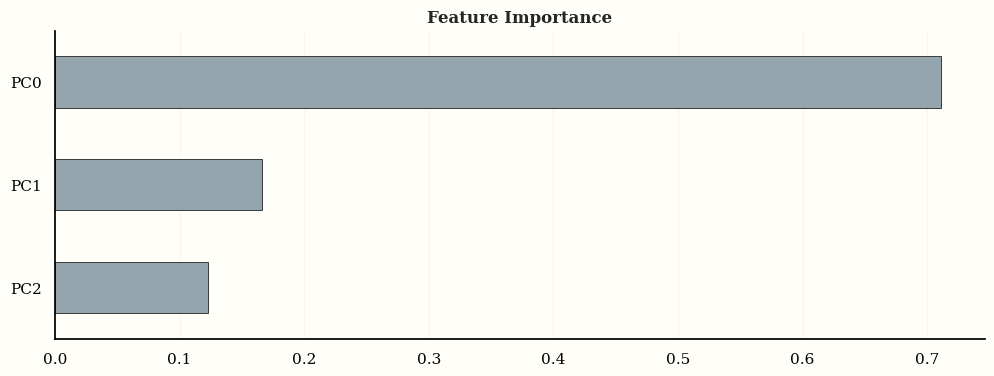

In [12]:
modelsLB = []
predsLB = []

lgbr_params = {
            'n_estimators': 9999,
            'max_depth': 5,
            'learning_rate': 0.00693702575527996,
            'subsample': 0.20851841295589477,
            'colsample_bytree': 0.5784778854092203,
            'reg_alpha': 0.2622912287429849,
            'reg_lambda': 2.8702494234117617e-08,
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
           
            'random_state': CFG.SEED
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMClassifier(**lgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          eval_metric = 'logloss',
          early_stopping_rounds = CFG.XG_PATIENCE,
          verbose = 150
         )
    modelsLB.append(model)
    predsLB.append(model.predict_proba(X_test)[:, 1])

In [13]:
get_fi(modelsLB, X, CFG)

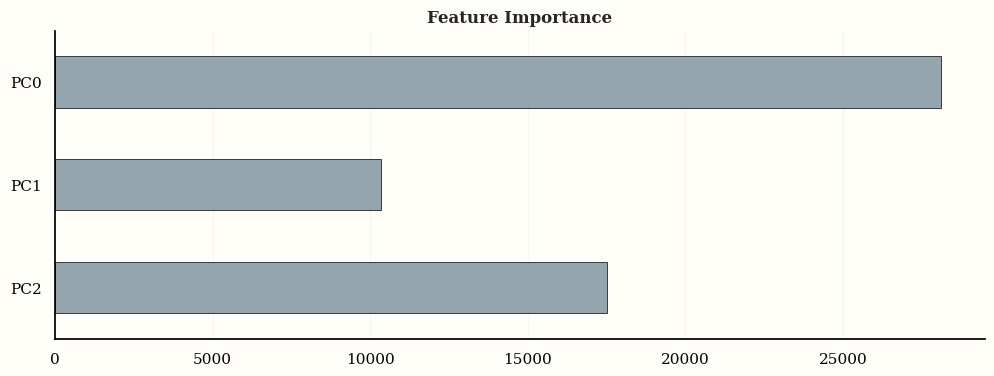

In [14]:
modelsRF = []
predsRF = []

params = {
        'criterion': 'log_loss',
        'n_jobs': -1,
        'random_state': CFG.SEED,
        'verbose': False
    }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(**params)
    model.fit(X=X_train, y=y_train)
    yprobas = model.predict_proba(X_valid)
    ypred = model.predict(X_valid)
    score = log_loss(y_valid, ypred)
    print(f'Score: {score}')
    
    modelsRF.append(model)
    predsRF.append(model.predict_proba(test)[:, 1])
    wandb.sklearn.plot_classifier(model, 
                               X_train, X_valid, 
                               y_train, y_valid,
                               ypred, yprobas,
                               [0, 1],
                               is_binary=True, 
                               model_name='RandomForest')

In [15]:
wand_params = {key:val for key, val in xgbr_params.items() if key not in ['random_state', 'eval_metric', 'verbosity', 'objective', 'n_jobs']}
wand_params

{'n_estimators': 9999,
 'max_depth': 4,
 'learning_rate': 0.05333221939055333,
 'min_child_weight': 4,
 'gamma': 5.301218558776368e-08,
 'subsample': 0.41010429946197946,
 'colsample_bytree': 0.8298539920447499,
 'reg_alpha': 0.000517878113716743,
 'reg_lambda': 0.00030121415155097723}

In [16]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

wandb.init(project='S3E10', name='XGBoost', group='XGBoost')
config = dict()